In [1]:
%matplotlib inline

# Transfer Learning
In this assignment, we will use the weights of a network pre-trained in a particular problem as starting point to train our CNN to a different problem. As training a network from scratch is time-consuming and demands a lot of data, this is a frequent strategy, specially if both datasets (the one used for pre-training and the target) shares similar structures/elements/concepts. 

This is specially true when working with images. Most filters learned in initial convolutional layers will detect low-level elements, such as borders, corners and color blobs, which are common to most problems in the image domain. 

In this notebook, we will load the SqueezeNet architecture trained in the ImageNet dataset and fine-tune it to CIFAR-10.

## Imports

In [2]:
!pip install keras==2.2.4

In [3]:
import os
import numpy as np
import sklearn
import keras
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from random import sample, seed
seed(42)
np.random.seed(42)
from time import time
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras import regularizers
from keras import optimizers
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
if (sklearn.__version__ == '0.20.0'):
    from sklearn.model_selection import StratifiedShuffleSplit
else:
    from sklearn.cross_validation import StratifiedShuffleSplit


#======================================
# Global definitions
#======================================
n_epochs         = 100
learning_rate    = 1e-4
n_classes        = 10
train_batch_size = 384
val_batch_size   = 128
    
#Utility to plot
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
        
        
def plotImage(img):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

Using TensorFlow backend.


The scikit-learn version is 0.20.0.


## SqueezeNet definition
These methods define our architecture and load the weights obtained using ImageNet data.

In [4]:
# Fire Module Definition
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

#SqueezeNet model definition
def SqueezeNet(input_shape):
    img_input = Input(shape=input_shape) #placeholder
    
    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(1000, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')

    # Download and load ImageNet weights
    model.load_weights('./squeezenet_weights_tf_dim_ordering_tf_kernels.h5')
    
    return model    

## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The class are **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck**.

In [5]:
#Load data
(trainVal_data, trainVal_label), (X_test, y_test) = cifar10.load_data()
print("Train/Val data. X: ", trainVal_data.shape, ", Y: ", trainVal_label.shape)
print("Test data. X: ", X_test.shape, ", Y: ", y_test.shape)

# Normalizing the data
trainVal_data = (trainVal_data / 127.5) - 1.
X_test = (X_test  / 127.5) - 1.

#=====================================
# Prepare the data
#=====================================

#--- Dividing the data into training and validation
folds = 5
if (sklearn.__version__ == '0.20.0'):
    sss = StratifiedShuffleSplit(folds, test_size=0.2, random_state=42)
    sss = sss.split(trainVal_data,trainVal_label)
else:
    sss = StratifiedShuffleSplit(trainVal_label, folds, test_size=0.2, random_state=42)
X_train = []
y_train = []
X_val = []
y_val = []
for train_index, val_index in sss:
    X_train.append(trainVal_data[train_index])
    X_val.append(trainVal_data[val_index])
    y_train.append(trainVal_label[train_index])
    y_val.append(trainVal_label[val_index])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
    
print("--- Splitting data into train and val")
print("Train data. X:",X_train.shape,"Y:",y_train.shape)
print("Val data. X:",X_val.shape,"Y:",y_val.shape)

Train/Val data. X:  (50000, 32, 32, 3) , Y:  (50000, 1)
Test data. X:  (10000, 32, 32, 3) , Y:  (10000, 1)
--- Splitting data into train and val
Train data. X: (5, 40000, 32, 32, 3) Y: (5, 40000, 1)
Val data. X: (5, 10000, 32, 32, 3) Y: (5, 10000, 1)


[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


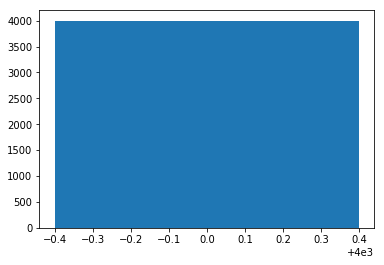

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


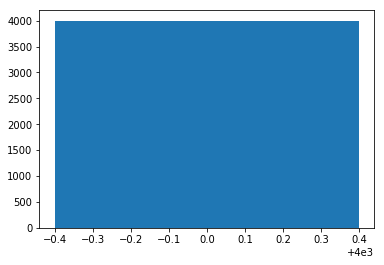

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


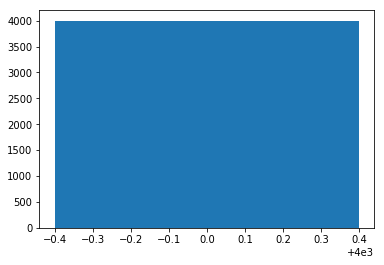

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


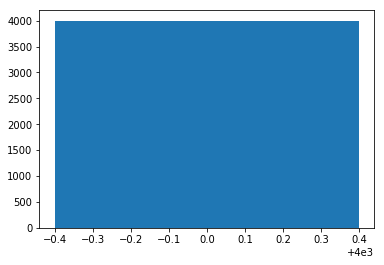

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


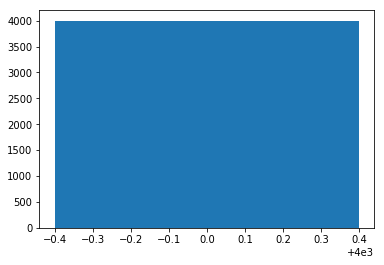

<Figure size 432x288 with 0 Axes>

In [6]:
# Cheking if the splits are balanced
for i in range(folds):
    hist = np.histogram(np.squeeze(y_train[i]))[0]
    print(hist)    
    plt.bar(hist,np.amax(hist),alpha=0.5)
    plt.show()
    plt.clf()

-----------------
## SqueezeNet with frozen layers
Our initial attempt will be to remove SqueezeNet's top layers --- responsible for the classification into ImageNet classes --- and train a new set of layers to our CIFAR-10 classes. We will also freeze the layers before `drop9`. Our architecture will be like this:

<img src="frozenSqueezeNet.png" width=70% height=70%>

In [7]:
def get_squeezenet_ft():
    #=====================================
    # Freezing layers
    #=====================================

    squeezeNetModel = SqueezeNet((32,32,3))

    #freeze layers
    for layer in squeezeNetModel.layers:
        layer.trainable = False

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    #=====================================
    # Compile model
    #=====================================


    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

model  = get_squeezenet_ft()
model.summary()

#--- Check the trainable status of the individual layers
for layer in model.layers:
    print(layer.name, layer.trainable)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/sque

Now, we compile our model and train it:

In [8]:
#=====================================
# Training model and Evaluation
#=====================================

y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)

scores = []
for i in range(folds):
    #--- Loading model
    model  = get_squeezenet_ft()

    
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    print("================================================")
    
    #=====================================
    # Tensorboard callback
    #=====================================
    print("--- Preparing tensorboard")
    log_dir = "logs/{}_fold[{}]_{}".format(time(), i, 'pre-trained')
    print("Log Dir: ", log_dir)
    tbCallBack = TensorBoard(log_dir=log_dir, write_graph=True)    
    
    # Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size, 
              epochs=n_epochs, 
              validation_data=(X_val[i],y_val_categorical[i]),
              verbose=1,
              callbacks=[tbCallBack])
    
    #--- Evaluating the model for split i
    score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    
#--- Showing scores
print(scores)

Split: 0
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 384
Val batch size: 128
--- Preparing tensorboard
Log Dir:  logs/1542744509.6199977_fold[0]_pre-trained
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 3s 75us/step - loss: 2.3576 - acc: 0.1032 - val_loss: 2.3014 - val_acc: 0.1100
Epoch 2/100
40000/40000 [==============================] - 1s 32us/step - loss: 2.3156 - acc: 0.1141 - val_loss: 2.2907 - val_acc: 0.1386
Epoch 3/100
40000/40000 [==============================] - 1s 33us/step - loss: 2.2945 - acc: 0.1318 - val_loss: 2.2770 - val_acc: 0.1859
Epoch 4/100
40000/40000 [==============================] - 1s 34us/step - loss: 2.2815 - acc: 0.1454 - val_loss: 2.2573 - val_acc: 0.2170
Epoch 5/100
40000/40000 [==============================] - 1s 32us/step - loss: 2.2629 - acc: 0.1673 - val_loss: 2.2298 - val_acc: 0.2449
Epoch 6/100
40000/40000 [==============================] - 1s 33us/step - l

40000/40000 [==============================] - 1s 31us/step - loss: 1.8105 - acc: 0.3531 - val_loss: 1.7193 - val_acc: 0.4140
Epoch 58/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8053 - acc: 0.3577 - val_loss: 1.7178 - val_acc: 0.4137
Epoch 59/100
40000/40000 [==============================] - 1s 32us/step - loss: 1.8078 - acc: 0.3561 - val_loss: 1.7164 - val_acc: 0.4122
Epoch 60/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8104 - acc: 0.3530 - val_loss: 1.7151 - val_acc: 0.4146
Epoch 61/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8068 - acc: 0.3538 - val_loss: 1.7139 - val_acc: 0.4142
Epoch 62/100
40000/40000 [==============================] - 1s 36us/step - loss: 1.8077 - acc: 0.3556 - val_loss: 1.7126 - val_acc: 0.4144
Epoch 63/100
40000/40000 [==============================] - 1s 36us/step - loss: 1.8027 - acc: 0.3548 - val_loss: 1.7117 - val_acc: 0.4136
Epoch 64/100
40000/40000 [==============

Epoch 13/100
40000/40000 [==============================] - 1s 31us/step - loss: 2.0620 - acc: 0.2697 - val_loss: 1.9660 - val_acc: 0.3537
Epoch 14/100
40000/40000 [==============================] - 1s 32us/step - loss: 2.0341 - acc: 0.2739 - val_loss: 1.9401 - val_acc: 0.3564
Epoch 15/100
40000/40000 [==============================] - 1s 31us/step - loss: 2.0081 - acc: 0.2826 - val_loss: 1.9206 - val_acc: 0.3647
Epoch 16/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.9894 - acc: 0.2922 - val_loss: 1.9049 - val_acc: 0.3694
Epoch 17/100
40000/40000 [==============================] - 1s 32us/step - loss: 1.9704 - acc: 0.2963 - val_loss: 1.8911 - val_acc: 0.3714
Epoch 18/100
40000/40000 [==============================] - 1s 32us/step - loss: 1.9575 - acc: 0.3032 - val_loss: 1.8790 - val_acc: 0.3784
Epoch 19/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.9438 - acc: 0.3072 - val_loss: 1.8682 - val_acc: 0.3791
Epoch 20/100
40000/40000 [=

Epoch 72/100
40000/40000 [==============================] - 1s 32us/step - loss: 1.7955 - acc: 0.3608 - val_loss: 1.7065 - val_acc: 0.4124
Epoch 73/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.7923 - acc: 0.3613 - val_loss: 1.7055 - val_acc: 0.4158
Epoch 74/100
40000/40000 [==============================] - 1s 32us/step - loss: 1.7914 - acc: 0.3603 - val_loss: 1.7043 - val_acc: 0.4149
Epoch 75/100
40000/40000 [==============================] - 1s 32us/step - loss: 1.7925 - acc: 0.3606 - val_loss: 1.7034 - val_acc: 0.4148
Epoch 76/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.7932 - acc: 0.3574 - val_loss: 1.7027 - val_acc: 0.4147
Epoch 77/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.7919 - acc: 0.3584 - val_loss: 1.7020 - val_acc: 0.4160
Epoch 78/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.7892 - acc: 0.3621 - val_loss: 1.7010 - val_acc: 0.4158
Epoch 79/100
40000/40000 [=

40000/40000 [==============================] - 1s 31us/step - loss: 1.8820 - acc: 0.3337 - val_loss: 1.7940 - val_acc: 0.3986
Epoch 28/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8779 - acc: 0.3322 - val_loss: 1.7886 - val_acc: 0.3994
Epoch 29/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8750 - acc: 0.3336 - val_loss: 1.7838 - val_acc: 0.4002
Epoch 30/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8707 - acc: 0.3347 - val_loss: 1.7789 - val_acc: 0.3989
Epoch 31/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8645 - acc: 0.3372 - val_loss: 1.7745 - val_acc: 0.3993
Epoch 32/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8636 - acc: 0.3383 - val_loss: 1.7704 - val_acc: 0.4002
Epoch 33/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8574 - acc: 0.3391 - val_loss: 1.7663 - val_acc: 0.4008
Epoch 34/100
40000/40000 [==============

40000/40000 [==============================] - 1s 31us/step - loss: 1.7890 - acc: 0.3629 - val_loss: 1.6787 - val_acc: 0.4217
Epoch 87/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.7913 - acc: 0.3611 - val_loss: 1.6779 - val_acc: 0.4197
Epoch 88/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.7897 - acc: 0.3590 - val_loss: 1.6774 - val_acc: 0.4207
Epoch 89/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.7885 - acc: 0.3628 - val_loss: 1.6767 - val_acc: 0.4215
Epoch 90/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.7843 - acc: 0.3648 - val_loss: 1.6760 - val_acc: 0.4222
Epoch 91/100
40000/40000 [==============================] - 1s 32us/step - loss: 1.7852 - acc: 0.3623 - val_loss: 1.6754 - val_acc: 0.4223
Epoch 92/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.7874 - acc: 0.3641 - val_loss: 1.6747 - val_acc: 0.4216
Epoch 93/100
40000/40000 [==============

Epoch 42/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8352 - acc: 0.3454 - val_loss: 1.7442 - val_acc: 0.4054
Epoch 43/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8306 - acc: 0.3461 - val_loss: 1.7416 - val_acc: 0.4060
Epoch 44/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8254 - acc: 0.3488 - val_loss: 1.7394 - val_acc: 0.4066
Epoch 45/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8278 - acc: 0.3480 - val_loss: 1.7369 - val_acc: 0.4073
Epoch 46/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8246 - acc: 0.3501 - val_loss: 1.7347 - val_acc: 0.4058
Epoch 47/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8257 - acc: 0.3491 - val_loss: 1.7327 - val_acc: 0.4067
Epoch 48/100
40000/40000 [==============================] - 1s 31us/step - loss: 1.8256 - acc: 0.3466 - val_loss: 1.7307 - val_acc: 0.4091
Epoch 49/100
40000/40000 [=

10000/10000 [==============================] - 0s 31us/step
Validation loss: 1.678535629272461
Validation accuracy (NORMALIZED): 0.4196
Split: 4
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 384
Val batch size: 128
--- Preparing tensorboard
Log Dir:  logs/1542745034.5268083_fold[4]_pre-trained
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 2s 39us/step - loss: 2.3281 - acc: 0.1118 - val_loss: 2.2958 - val_acc: 0.1300
Epoch 2/100
40000/40000 [==============================] - 1s 32us/step - loss: 2.2993 - acc: 0.1286 - val_loss: 2.2835 - val_acc: 0.1718
Epoch 3/100
40000/40000 [==============================] - 1s 32us/step - loss: 2.2864 - acc: 0.1389 - val_loss: 2.2691 - val_acc: 0.2082
Epoch 4/100
40000/40000 [==============================] - 1s 32us/step - loss: 2.2667 - acc: 0.1595 - val_loss: 2.2359 - val_acc: 0.2422
Epoch 5/100
40000/40000 [==============================] - 1s 32us/step - los

40000/40000 [==============================] - 1s 32us/step - loss: 1.8081 - acc: 0.3542 - val_loss: 1.7122 - val_acc: 0.4115
Epoch 57/100
40000/40000 [==============================] - 1s 32us/step - loss: 1.8126 - acc: 0.3546 - val_loss: 1.7111 - val_acc: 0.4108
Epoch 58/100
40000/40000 [==============================] - 1s 32us/step - loss: 1.8031 - acc: 0.3580 - val_loss: 1.7095 - val_acc: 0.4104
Epoch 59/100
40000/40000 [==============================] - 1s 32us/step - loss: 1.8075 - acc: 0.3578 - val_loss: 1.7082 - val_acc: 0.4124
Epoch 60/100
40000/40000 [==============================] - 1s 33us/step - loss: 1.8054 - acc: 0.3572 - val_loss: 1.7068 - val_acc: 0.4119
Epoch 61/100
40000/40000 [==============================] - 1s 32us/step - loss: 1.8066 - acc: 0.3564 - val_loss: 1.7056 - val_acc: 0.4121
Epoch 62/100
40000/40000 [==============================] - 1s 32us/step - loss: 1.8015 - acc: 0.3578 - val_loss: 1.7044 - val_acc: 0.4124
Epoch 63/100
40000/40000 [==============

Finally, let's evaluate on our test set:

In [9]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 1.6783039318466186
Mean Validation accuracy (NORMALIZED): 0.41978


-----------------
-----------------

# Training last 2 Fire Modules + classification layers
As we could see, the frozen network performed very poorly. By freezing most layers, we do not allow SqueezeNet to adapt its weights to features present in CIFAR-10.

Let's try to unfreeze the last two fire modules and train once more. The architecture will be:
<img src="partFrozenSqueezeNet.png" width=70% height=70%>

In [10]:
def get_squeezenet_ft2():
    squeezeNetModel = SqueezeNet((32,32,3))

    #=====================================
    # Freezing mentioned layers
    #=====================================

    trainable_layer_index = 19
    for i in range(len(squeezeNetModel.layers)-trainable_layer_index):
        squeezeNetModel.layers[i].trainable = False

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

model = get_squeezenet_ft2()
model.summary()

#--- Check the trainable status of the individual layers
for layer in model.layers:
    print(layer.name, layer.trainable)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_7[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/sque

Now, we compile our model and train it:

In [11]:
#=====================================
# Training model and Evaluation
#=====================================

y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)

scores = []
for i in range(folds):
    #--- Loading model
    model = get_squeezenet_ft2()    
    
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    print("================================================")
    
    #=====================================
    # Tensorboard callback
    #=====================================
    print("--- Preparing tensorboard")
    log_dir = "logs/{}_fold[{}]_{}".format(time(), i, 'fine-tunned')
    print("Log Dir: ", log_dir)
    tbCallBack = TensorBoard(log_dir=log_dir, write_graph=True)    
    
    # Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size, 
              epochs=n_epochs, 
              validation_data=(X_val[i],y_val_categorical[i]),
              verbose=1,
              callbacks=[tbCallBack])
    
    #--- Evaluating the model for split i
    score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    
#--- Showing scores
print(scores)

Split: 0
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 384
Val batch size: 128
--- Preparing tensorboard
Log Dir:  logs/1542745167.5783021_fold[0]_fine-tunned
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 2s 54us/step - loss: 2.2367 - acc: 0.1845 - val_loss: 2.0404 - val_acc: 0.3121
Epoch 2/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.8945 - acc: 0.3330 - val_loss: 1.6590 - val_acc: 0.4238
Epoch 3/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.6940 - acc: 0.3953 - val_loss: 1.5580 - val_acc: 0.4509
Epoch 4/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.6133 - acc: 0.4262 - val_loss: 1.5058 - val_acc: 0.4665
Epoch 5/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.5662 - acc: 0.4433 - val_loss: 1.4765 - val_acc: 0.4796
Epoch 6/100
40000/40000 [==============================] - 2s 39us/step - l

40000/40000 [==============================] - 2s 40us/step - loss: 1.2608 - acc: 0.5543 - val_loss: 1.2879 - val_acc: 0.5468
Epoch 58/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.2595 - acc: 0.5538 - val_loss: 1.2902 - val_acc: 0.5467
Epoch 59/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.2615 - acc: 0.5551 - val_loss: 1.2878 - val_acc: 0.5462
Epoch 60/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.2548 - acc: 0.5571 - val_loss: 1.2912 - val_acc: 0.5448
Epoch 61/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.2527 - acc: 0.5572 - val_loss: 1.2847 - val_acc: 0.5480
Epoch 62/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.2538 - acc: 0.5572 - val_loss: 1.2846 - val_acc: 0.5480
Epoch 63/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.2501 - acc: 0.5592 - val_loss: 1.2876 - val_acc: 0.5463
Epoch 64/100
40000/40000 [==============

Epoch 13/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.4222 - acc: 0.4984 - val_loss: 1.3877 - val_acc: 0.5056
Epoch 14/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.4149 - acc: 0.4973 - val_loss: 1.3873 - val_acc: 0.5053
Epoch 15/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.4056 - acc: 0.5039 - val_loss: 1.3767 - val_acc: 0.5129
Epoch 16/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.3976 - acc: 0.5064 - val_loss: 1.3737 - val_acc: 0.5115
Epoch 17/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.3896 - acc: 0.5091 - val_loss: 1.3671 - val_acc: 0.5117
Epoch 18/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.3837 - acc: 0.5105 - val_loss: 1.3627 - val_acc: 0.5150
Epoch 19/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.3779 - acc: 0.5142 - val_loss: 1.3615 - val_acc: 0.5150
Epoch 20/100
40000/40000 [=

Epoch 72/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.2371 - acc: 0.5644 - val_loss: 1.2998 - val_acc: 0.5415
Epoch 73/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.2363 - acc: 0.5637 - val_loss: 1.2950 - val_acc: 0.5436
Epoch 74/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.2352 - acc: 0.5613 - val_loss: 1.2964 - val_acc: 0.5455
Epoch 75/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.2326 - acc: 0.5646 - val_loss: 1.2953 - val_acc: 0.5453
Epoch 76/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.2297 - acc: 0.5650 - val_loss: 1.2926 - val_acc: 0.5437
Epoch 77/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.2308 - acc: 0.5654 - val_loss: 1.3019 - val_acc: 0.5406
Epoch 78/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.2280 - acc: 0.5664 - val_loss: 1.2967 - val_acc: 0.5436
Epoch 79/100
40000/40000 [=

40000/40000 [==============================] - 2s 40us/step - loss: 1.3547 - acc: 0.5206 - val_loss: 1.3182 - val_acc: 0.5293
Epoch 28/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.3500 - acc: 0.5264 - val_loss: 1.3199 - val_acc: 0.5305
Epoch 29/100
40000/40000 [==============================] - 2s 41us/step - loss: 1.3481 - acc: 0.5253 - val_loss: 1.3192 - val_acc: 0.5303
Epoch 30/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.3433 - acc: 0.5274 - val_loss: 1.3182 - val_acc: 0.5301
Epoch 31/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.3387 - acc: 0.5287 - val_loss: 1.3152 - val_acc: 0.5321
Epoch 32/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.3369 - acc: 0.5304 - val_loss: 1.3102 - val_acc: 0.5325
Epoch 33/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.3296 - acc: 0.5327 - val_loss: 1.3065 - val_acc: 0.5338
Epoch 34/100
40000/40000 [==============

40000/40000 [==============================] - 2s 40us/step - loss: 1.2290 - acc: 0.5680 - val_loss: 1.2673 - val_acc: 0.5513
Epoch 87/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.2258 - acc: 0.5678 - val_loss: 1.2683 - val_acc: 0.5483
Epoch 88/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.2244 - acc: 0.5692 - val_loss: 1.2689 - val_acc: 0.5475
Epoch 89/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.2266 - acc: 0.5685 - val_loss: 1.2676 - val_acc: 0.5499
Epoch 90/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.2208 - acc: 0.5715 - val_loss: 1.2669 - val_acc: 0.5486
Epoch 91/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.2223 - acc: 0.5699 - val_loss: 1.2680 - val_acc: 0.5478
Epoch 92/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.2198 - acc: 0.5711 - val_loss: 1.2680 - val_acc: 0.5482
Epoch 93/100
40000/40000 [==============

Epoch 42/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.3000 - acc: 0.5403 - val_loss: 1.2993 - val_acc: 0.5366
Epoch 43/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.2964 - acc: 0.5419 - val_loss: 1.2996 - val_acc: 0.5345
Epoch 44/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.2910 - acc: 0.5446 - val_loss: 1.2993 - val_acc: 0.5368
Epoch 45/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.2920 - acc: 0.5437 - val_loss: 1.3004 - val_acc: 0.5376
Epoch 46/100
40000/40000 [==============================] - 2s 39us/step - loss: 1.2897 - acc: 0.5444 - val_loss: 1.2989 - val_acc: 0.5362
Epoch 47/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.2856 - acc: 0.5460 - val_loss: 1.3002 - val_acc: 0.5371
Epoch 48/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.2827 - acc: 0.5474 - val_loss: 1.2975 - val_acc: 0.5385
Epoch 49/100
40000/40000 [=

10000/10000 [==============================] - 0s 36us/step
Validation loss: 1.272544974708557
Validation accuracy (NORMALIZED): 0.5497
Split: 4
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 384
Val batch size: 128
--- Preparing tensorboard
Log Dir:  logs/1542745821.4284937_fold[4]_fine-tunned
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 2s 56us/step - loss: 2.2545 - acc: 0.1662 - val_loss: 2.1039 - val_acc: 0.2816
Epoch 2/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.9314 - acc: 0.3152 - val_loss: 1.6611 - val_acc: 0.4211
Epoch 3/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.6834 - acc: 0.4022 - val_loss: 1.5517 - val_acc: 0.4524
Epoch 4/100
40000/40000 [==============================] - 2s 41us/step - loss: 1.6031 - acc: 0.4285 - val_loss: 1.5081 - val_acc: 0.4644
Epoch 5/100
40000/40000 [==============================] - 2s 40us/step - los

40000/40000 [==============================] - 2s 40us/step - loss: 1.2651 - acc: 0.5530 - val_loss: 1.2964 - val_acc: 0.5398
Epoch 57/100
40000/40000 [==============================] - 2s 41us/step - loss: 1.2682 - acc: 0.5508 - val_loss: 1.2966 - val_acc: 0.5393
Epoch 58/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.2625 - acc: 0.5547 - val_loss: 1.2916 - val_acc: 0.5428
Epoch 59/100
40000/40000 [==============================] - 2s 41us/step - loss: 1.2603 - acc: 0.5549 - val_loss: 1.2955 - val_acc: 0.5376
Epoch 60/100
40000/40000 [==============================] - 2s 42us/step - loss: 1.2597 - acc: 0.5590 - val_loss: 1.2895 - val_acc: 0.5415
Epoch 61/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.2587 - acc: 0.5573 - val_loss: 1.2894 - val_acc: 0.5415
Epoch 62/100
40000/40000 [==============================] - 2s 41us/step - loss: 1.2556 - acc: 0.5577 - val_loss: 1.2883 - val_acc: 0.5422
Epoch 63/100
40000/40000 [==============

Finally, let's evaluate on our test set:

In [12]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 1.2751283825683593
Mean Validation accuracy (NORMALIZED): 0.54848


-----------
-----------
-----------
# Tensorboard

Tensorboard is a visualization tool for Tensorflow. Among other things, it allows us to monitor the progress of our training, plot metrics per epochs, visualize the architecture's schematics. 

Just like for Early Stopping, we will use the [Tensorboard callback](https://keras.io/callbacks/#tensorboard) to log the information about our training. An example of usage, would be:

As your training progresses, Keras will log the metrics (e.g., loss, accuracy) to `<<LOG_DIR>>` (**make sure `<<LOG_DIR>>` is a valid directory)**. On your terminal, you will need to run Tensorboard, assign a port and access it via browser (just like jupyter).

#### ----> MAKE SURE YOU USE A DIFFERENT PORT FOR JUPYTER AND TENSORBOARD <----

### Docker
For those using docker, open a new terminal and create a new container (using the same image) running Tensorboard:

For example:

After starting Tensorboard, access it via browser on `http://localhost:<<port_container>>`.

### Anaconda
$ tensorboard --logdir=<<LOG_DIR>> --port=<<port>>

After starting Tensorboard, access it via browser on `http://localhost:<<port>>`.

-----------
-----------
-----------

# Fine-tuning all layers

What if we fine-tune all layers of SqueezeNet?
<img src="unfrozenSqueezeNet.png" width=70% height=70%>

In [13]:
def get_squeezenet_ft3():
    squeezeNetModel = SqueezeNet((32,32,3))

    for layer in squeezeNetModel.layers:
        layer.trainable = True       #by default they are all trainable, but just for clarification

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    print("--- Compiling model")
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

model = get_squeezenet_ft3()
model.summary()

--- Compiling model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_13[0][0]                   
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
_________________________________________________________________________________________

Now, we compile our model and train it:

In [14]:
from time import time



#=====================================
# Training model and Evaluation
#=====================================
print("--- Start training")
y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)
scores = []

for i in range(folds):
    #--- Loading model
    model = get_squeezenet_ft3()

    
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    print("================================================")
          
    #=====================================
    # Tensorboard callback
    #=====================================
    print("--- Preparing tensorboard")
    log_dir = "logs/{}_fold[{}]_{}".format(time(), i, 'fully-trained')
    print("Log Dir: ", log_dir)
    tbCallBack = TensorBoard(log_dir=log_dir, write_graph=True)    
    
    # Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size, 
              epochs=n_epochs, 
              validation_data=(X_val[i],y_val_categorical[i]),
              verbose=1,
              callbacks=[tbCallBack])
          
    #--- Evaluating the model for split i
    score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    
#--- Showing scores
print(scores)

--- Start training
--- Compiling model
Split: 0
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 384
Val batch size: 128
--- Preparing tensorboard
Log Dir:  logs/1542745991.8031373_fold[0]_fully-trained
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 4s 106us/step - loss: 2.0651 - acc: 0.2551 - val_loss: 1.5466 - val_acc: 0.4700
Epoch 2/100
40000/40000 [==============================] - 3s 73us/step - loss: 1.4453 - acc: 0.4947 - val_loss: 1.1812 - val_acc: 0.5921
Epoch 3/100
40000/40000 [==============================] - 3s 73us/step - loss: 1.1988 - acc: 0.5890 - val_loss: 1.0725 - val_acc: 0.6271
Epoch 4/100
40000/40000 [==============================] - 3s 73us/step - loss: 1.0886 - acc: 0.6323 - val_loss: 1.0070 - val_acc: 0.6545
Epoch 5/100
40000/40000 [==============================] - 3s 73us/step - loss: 1.0088 - acc: 0.6596 - val_loss: 0.9548 - val_acc: 0.6713
Epoch 6/100
40000/40000 [========

40000/40000 [==============================] - 3s 73us/step - loss: 0.2422 - acc: 0.9249 - val_loss: 1.0774 - val_acc: 0.7443
Epoch 58/100
40000/40000 [==============================] - 3s 73us/step - loss: 0.2342 - acc: 0.9274 - val_loss: 1.1065 - val_acc: 0.7451
Epoch 59/100
40000/40000 [==============================] - 3s 73us/step - loss: 0.2276 - acc: 0.9292 - val_loss: 1.1280 - val_acc: 0.7413
Epoch 60/100
40000/40000 [==============================] - 3s 73us/step - loss: 0.2181 - acc: 0.9332 - val_loss: 1.1263 - val_acc: 0.7472
Epoch 61/100
40000/40000 [==============================] - 3s 73us/step - loss: 0.2208 - acc: 0.9311 - val_loss: 1.1306 - val_acc: 0.7480
Epoch 62/100
40000/40000 [==============================] - 3s 73us/step - loss: 0.2131 - acc: 0.9343 - val_loss: 1.1661 - val_acc: 0.7434
Epoch 63/100
40000/40000 [==============================] - 3s 73us/step - loss: 0.2061 - acc: 0.9363 - val_loss: 1.1870 - val_acc: 0.7442
Epoch 64/100
40000/40000 [==============

40000/40000 [==============================] - 3s 77us/step - loss: 0.7971 - acc: 0.7355 - val_loss: 0.8722 - val_acc: 0.7035
Epoch 13/100
40000/40000 [==============================] - 3s 80us/step - loss: 0.7777 - acc: 0.7403 - val_loss: 0.8580 - val_acc: 0.7074
Epoch 14/100
40000/40000 [==============================] - 3s 79us/step - loss: 0.7534 - acc: 0.7479 - val_loss: 0.8453 - val_acc: 0.7163
Epoch 15/100
40000/40000 [==============================] - 3s 81us/step - loss: 0.7329 - acc: 0.7571 - val_loss: 0.8441 - val_acc: 0.7160
Epoch 16/100
40000/40000 [==============================] - 3s 80us/step - loss: 0.7140 - acc: 0.7643 - val_loss: 0.8394 - val_acc: 0.7166
Epoch 17/100
40000/40000 [==============================] - 3s 76us/step - loss: 0.6994 - acc: 0.7686 - val_loss: 0.8319 - val_acc: 0.7242
Epoch 18/100
40000/40000 [==============================] - 3s 77us/step - loss: 0.6802 - acc: 0.7749 - val_loss: 0.8376 - val_acc: 0.7206
Epoch 19/100
40000/40000 [==============

40000/40000 [==============================] - 3s 81us/step - loss: 0.1833 - acc: 0.9446 - val_loss: 1.2907 - val_acc: 0.7357
Epoch 72/100
40000/40000 [==============================] - 3s 74us/step - loss: 0.1762 - acc: 0.9463 - val_loss: 1.3224 - val_acc: 0.7343
Epoch 73/100
40000/40000 [==============================] - 3s 78us/step - loss: 0.1763 - acc: 0.9464 - val_loss: 1.3029 - val_acc: 0.7333
Epoch 74/100
40000/40000 [==============================] - 3s 77us/step - loss: 0.1767 - acc: 0.9457 - val_loss: 1.3333 - val_acc: 0.7373
Epoch 75/100
40000/40000 [==============================] - 3s 78us/step - loss: 0.1559 - acc: 0.9543 - val_loss: 1.3881 - val_acc: 0.7333
Epoch 76/100
40000/40000 [==============================] - 3s 80us/step - loss: 0.1698 - acc: 0.9491 - val_loss: 1.4294 - val_acc: 0.7350
Epoch 77/100
40000/40000 [==============================] - 3s 79us/step - loss: 0.1562 - acc: 0.9534 - val_loss: 1.3849 - val_acc: 0.7324
Epoch 78/100
40000/40000 [==============

40000/40000 [==============================] - 3s 77us/step - loss: 0.5847 - acc: 0.8060 - val_loss: 0.7992 - val_acc: 0.7418
Epoch 27/100
40000/40000 [==============================] - 3s 77us/step - loss: 0.5708 - acc: 0.8103 - val_loss: 0.8176 - val_acc: 0.7404
Epoch 28/100
40000/40000 [==============================] - 3s 81us/step - loss: 0.5638 - acc: 0.8141 - val_loss: 0.8190 - val_acc: 0.7361
Epoch 29/100
40000/40000 [==============================] - 3s 80us/step - loss: 0.5505 - acc: 0.8189 - val_loss: 0.8049 - val_acc: 0.7406
Epoch 30/100
40000/40000 [==============================] - 3s 77us/step - loss: 0.5355 - acc: 0.8240 - val_loss: 0.7995 - val_acc: 0.7431
Epoch 31/100
40000/40000 [==============================] - 3s 76us/step - loss: 0.5236 - acc: 0.8279 - val_loss: 0.8054 - val_acc: 0.7464
Epoch 32/100
40000/40000 [==============================] - 3s 77us/step - loss: 0.5198 - acc: 0.8263 - val_loss: 0.8130 - val_acc: 0.7458
Epoch 33/100
40000/40000 [==============

40000/40000 [==============================] - 3s 74us/step - loss: 0.1433 - acc: 0.9564 - val_loss: 1.4384 - val_acc: 0.7408
Epoch 86/100
40000/40000 [==============================] - 3s 74us/step - loss: 0.1464 - acc: 0.9555 - val_loss: 1.4268 - val_acc: 0.7410
Epoch 87/100
40000/40000 [==============================] - 3s 74us/step - loss: 0.1438 - acc: 0.9566 - val_loss: 1.4561 - val_acc: 0.7446
Epoch 88/100
40000/40000 [==============================] - 3s 74us/step - loss: 0.1418 - acc: 0.9569 - val_loss: 1.4938 - val_acc: 0.7431
Epoch 89/100
40000/40000 [==============================] - 3s 74us/step - loss: 0.1327 - acc: 0.9600 - val_loss: 1.5234 - val_acc: 0.7414
Epoch 90/100
40000/40000 [==============================] - 3s 74us/step - loss: 0.1535 - acc: 0.9526 - val_loss: 1.4606 - val_acc: 0.7436
Epoch 91/100
40000/40000 [==============================] - 3s 74us/step - loss: 0.1277 - acc: 0.9613 - val_loss: 1.4923 - val_acc: 0.7446
Epoch 92/100
40000/40000 [==============

40000/40000 [==============================] - 3s 75us/step - loss: 0.4124 - acc: 0.8670 - val_loss: 0.8532 - val_acc: 0.7488
Epoch 41/100
40000/40000 [==============================] - 3s 75us/step - loss: 0.4018 - acc: 0.8715 - val_loss: 0.8611 - val_acc: 0.7494
Epoch 42/100
40000/40000 [==============================] - 3s 75us/step - loss: 0.3993 - acc: 0.8727 - val_loss: 0.8839 - val_acc: 0.7419
Epoch 43/100
40000/40000 [==============================] - 3s 75us/step - loss: 0.3883 - acc: 0.8755 - val_loss: 0.8698 - val_acc: 0.7472
Epoch 44/100
40000/40000 [==============================] - 3s 75us/step - loss: 0.3776 - acc: 0.8798 - val_loss: 0.8713 - val_acc: 0.7512
Epoch 45/100
40000/40000 [==============================] - 3s 75us/step - loss: 0.3642 - acc: 0.8839 - val_loss: 0.8862 - val_acc: 0.7508
Epoch 46/100
40000/40000 [==============================] - 3s 75us/step - loss: 0.3534 - acc: 0.8873 - val_loss: 0.9007 - val_acc: 0.7504
Epoch 47/100
40000/40000 [==============

40000/40000 [==============================] - 3s 75us/step - loss: 0.0843 - acc: 0.9772 - val_loss: 1.7598 - val_acc: 0.7417
Epoch 100/100
10000/10000 [==============================] - 0s 43us/step
Validation loss: 1.7529984481811522
Validation accuracy (NORMALIZED): 0.7448
--- Compiling model
Split: 4
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 384
Val batch size: 128
--- Preparing tensorboard
Log Dir:  logs/1542747242.5939288_fold[4]_fully-trained
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 5s 113us/step - loss: 2.0348 - acc: 0.2672 - val_loss: 1.5443 - val_acc: 0.4708
Epoch 2/100
40000/40000 [==============================] - 3s 76us/step - loss: 1.4651 - acc: 0.4936 - val_loss: 1.2230 - val_acc: 0.5709
Epoch 3/100
40000/40000 [==============================] - 3s 76us/step - loss: 1.2567 - acc: 0.5683 - val_loss: 1.1096 - val_acc: 0.6194
Epoch 4/100
40000/40000 [==========================

40000/40000 [==============================] - 3s 76us/step - loss: 0.2875 - acc: 0.9077 - val_loss: 1.0071 - val_acc: 0.7551
Epoch 55/100
40000/40000 [==============================] - 3s 76us/step - loss: 0.2833 - acc: 0.9080 - val_loss: 1.0513 - val_acc: 0.7484
Epoch 56/100
40000/40000 [==============================] - 3s 76us/step - loss: 0.2801 - acc: 0.9082 - val_loss: 1.0378 - val_acc: 0.7477
Epoch 57/100
40000/40000 [==============================] - 3s 76us/step - loss: 0.2627 - acc: 0.9164 - val_loss: 1.0414 - val_acc: 0.7514
Epoch 58/100
40000/40000 [==============================] - 3s 76us/step - loss: 0.2638 - acc: 0.9158 - val_loss: 1.0718 - val_acc: 0.7501
Epoch 59/100
40000/40000 [==============================] - 3s 76us/step - loss: 0.2691 - acc: 0.9130 - val_loss: 1.0504 - val_acc: 0.7484
Epoch 60/100
40000/40000 [==============================] - 3s 76us/step - loss: 0.2536 - acc: 0.9185 - val_loss: 1.0882 - val_acc: 0.7477
Epoch 61/100
40000/40000 [==============

Finally, let's evaluate on our validation set:

In [15]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 1.7541925602340698
Mean Validation accuracy (NORMALIZED): 0.73848


In [16]:
# Evaluate your best model on test
# ... 
# Done with the loading model cell

## Saving the model
Now that we are working on more complex tasks and our trainings are starting to take more time it is usually a good idea to save the trained model from time to time. [Keras has a lot of ways of saving and loading the model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model), but in this exercise we will use the simplest of them all: `model.save()`. It saves the architecture, the weights, the choice of loss function/optimizer/metrics and even the current state of the training, so you can resume your training later.

In [17]:
## The better model obtained was when retraining the whole network 
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

## Loading a model
Once we have our model trained, we can load it using:

In [18]:
from keras.models import load_model

del model  # Will delete model, only to check if load_model is working

y_test_categorical = to_categorical(y_test, num_classes=n_classes)

# returns a compiled model identical to the previous one
model = load_model('my_model.h5')

score = model.evaluate(x=X_test, y=y_test_categorical, batch_size=val_batch_size, verbose=1)    
# evaluate test set again... should give us the same result
# ...
print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])

10000/10000 [==============================] - 2s 211us/step
Test loss: 1.7840327156066895
Test accuracy (NORMALIZED): 0.7375


## Bonus Run

* Using the whole traning 
* Adding early stop as a callback 

In [19]:
from time import time

model = get_squeezenet_ft3()
    
#--- Evaluating the model for split i
print("================================================")
print("Number of Epochs: "+str(n_epochs))
print("Train shape:",trainVal_label.shape[0] * 0.95)
print("Train batch size: "+str(train_batch_size))
print("Val batch size: "+str(val_batch_size))
#print("Optimizer:", opt)
print("================================================")

y_train_categorical = to_categorical(trainVal_label, num_classes=n_classes)

earlyStopcb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                            patience=10, verbose=1, mode='auto', 
                                            baseline=None, restore_best_weights=True)
print("--- Preparing tensorboard")
log_dir = "logs/{}".format(time())
print("Log Dir: ", log_dir)
tbCallBack = TensorBoard(log_dir=log_dir, write_graph=True)


#--- Training without data augmentation
model.fit(trainVal_data,y_train_categorical, batch_size=train_batch_size,
          epochs=n_epochs, 
          validation_split=0.05,
          verbose=1,
          callbacks=[tbCallBack, earlyStopcb])


model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'


--- Compiling model
Number of Epochs: 100
Train shape: 47500.0
Train batch size: 384
Val batch size: 128
--- Preparing tensorboard
Log Dir:  logs/1542747580.8250608
Train on 47500 samples, validate on 2500 samples
Epoch 1/100
47500/47500 [==============================] - 6s 117us/step - loss: 1.9774 - acc: 0.2813 - val_loss: 1.3808 - val_acc: 0.5240
Epoch 2/100
47500/47500 [==============================] - 4s 78us/step - loss: 1.3706 - acc: 0.5188 - val_loss: 1.1434 - val_acc: 0.6084
Epoch 3/100
47500/47500 [==============================] - 4s 77us/step - loss: 1.1731 - acc: 0.5941 - val_loss: 1.0357 - val_acc: 0.6436
Epoch 4/100
47500/47500 [==============================] - 4s 78us/step - loss: 1.0752 - acc: 0.6312 - val_loss: 0.9569 - val_acc: 0.6784
Epoch 5/100
47500/47500 [==============================] - 4s 78us/step - loss: 0.9991 - acc: 0.6629 - val_loss: 0.9317 - val_acc: 0.6808
Epoch 6/100
47500/47500 [==============================] - 4s 77us/step - loss: 0.9440 - acc: 0

In [20]:
from keras.models import load_model


del model  # Will delete model, only to check if load_model is working

y_test_categorical = to_categorical(y_test, num_classes=n_classes)

# returns a compiled model identical to the previous one
model = load_model('my_model.h5')

score = model.evaluate(x=X_test, y=y_test_categorical, batch_size=val_batch_size, verbose=1)    
# evaluate test set again... should give us the same result
# ...
print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])

10000/10000 [==============================] - 3s 258us/step
Test loss: 0.7755689340591431
Test accuracy (NORMALIZED): 0.7445
